Globale Einstellungen wie Zufallsgenerator und MPL

In [1]:
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import numpy as np
rs = RandomState(MT19937(SeedSequence(2 ** 31 - 1)))
def reseed(seed = 2 ** 31 - 1):
    global rs
    np.random.seed(seed)
    rs = RandomState(MT19937(SeedSequence(seed)))

In [2]:
import matplotlib as plt
plt.rcParams["font.family"] = "Tex Gyre Termes"
plt.rcParams["font.size"] = 24

Die Implementierten Rauschgeneratoren.

In [3]:
# This is sourced from https://github.com/felixpatzelt/colorednoise/blob/master/colorednoise.py
# 
# Accessed: 17.11.2025
from typing import Union, Iterable, Optional
from numpy import sqrt, newaxis, integer
from numpy.fft import irfft, rfftfreq
from numpy.random import default_rng, Generator, RandomState
from numpy import sum as npsum


def powerlaw_psd_gaussian(
        exponent: float, 
        size: Union[int, Iterable[int]], 
        fmin: float = 0.0, 
        random_state: Optional[Union[int, Generator, RandomState]] = None
    ):
    """Gaussian (1/f)**beta noise.

    Based on the algorithm in:
    Timmer, J. and Koenig, M.:
    On generating power law noise.
    Astron. Astrophys. 300, 707-710 (1995)

    Normalised to unit variance

    Parameters:
    -----------

    exponent : float
        The power-spectrum of the generated noise is proportional to

        S(f) = (1 / f)**beta
        flicker / pink noise:   exponent beta = 1
        brown noise:            exponent beta = 2

        Furthermore, the autocorrelation decays proportional to lag**-gamma
        with gamma = 1 - beta for 0 < beta < 1.
        There may be finite-size issues for beta close to one.

    shape : int or iterable
        The output has the given shape, and the desired power spectrum in
        the last coordinate. That is, the last dimension is taken as time,
        and all other components are independent.

    fmin : float, optional
        Low-frequency cutoff.
        Default: 0 corresponds to original paper. 
        
        The power-spectrum below fmin is flat. fmin is defined relative
        to a unit sampling rate (see numpy's rfftfreq). For convenience,
        the passed value is mapped to max(fmin, 1/samples) internally
        since 1/samples is the lowest possible finite frequency in the
        sample. The largest possible value is fmin = 0.5, the Nyquist
        frequency. The output for this value is white noise.

    random_state :  int, numpy.integer, numpy.random.Generator, numpy.random.RandomState, 
                    optional
        Optionally sets the state of NumPy's underlying random number generator.
        Integer-compatible values or None are passed to np.random.default_rng.
        np.random.RandomState or np.random.Generator are used directly.
        Default: None.

    Returns
    -------
    out : array
        The samples.


    Examples:
    ---------

    # generate 1/f noise == pink noise == flicker noise
    >>> import colorednoise as cn
    >>> y = cn.powerlaw_psd_gaussian(1, 5)
    """
    
    # Make sure size is a list so we can iterate it and assign to it.
    if isinstance(size, (integer, int)):
        size = [size]
    elif isinstance(size, Iterable):
        size = list(size)
    else:
        raise ValueError("Size must be of type int or Iterable[int]")
    
    # The number of samples in each time series
    samples = size[-1]
    
    # Calculate Frequencies (we asume a sample rate of one)
    # Use fft functions for real output (-> hermitian spectrum)
    f = rfftfreq(samples) # type: ignore # mypy 1.5.1 has problems here 
    
    # Validate / normalise fmin
    if 0 <= fmin <= 0.5:
        fmin = max(fmin, 1./samples) # Low frequency cutoff
    else:
        raise ValueError("fmin must be chosen between 0 and 0.5.")
    
    # Build scaling factors for all frequencies
    s_scale = f    
    ix   = npsum(s_scale < fmin)   # Index of the cutoff
    if ix and ix < len(s_scale):
        s_scale[:ix] = s_scale[ix]
    s_scale = s_scale**(-exponent/2.)
    
    # Calculate theoretical output standard deviation from scaling
    w      = s_scale[1:].copy()
    w[-1] *= (1 + (samples % 2)) / 2. # correct f = +-0.5
    sigma = 2 * sqrt(npsum(w**2)) / samples
    
    # Adjust size to generate one Fourier component per frequency
    size[-1] = len(f)

    # Add empty dimension(s) to broadcast s_scale along last
    # dimension of generated random power + phase (below)
    dims_to_add = len(size) - 1
    s_scale     = s_scale[(newaxis,) * dims_to_add + (Ellipsis,)]
    
    # prepare random number generator
    normal_dist = _get_normal_distribution(random_state)

    # Generate scaled random power + phase
    sr = normal_dist(scale=s_scale, size=size)
    si = normal_dist(scale=s_scale, size=size)
    
    # If the signal length is even, frequencies +/- 0.5 are equal
    # so the coefficient must be real.
    if not (samples % 2):
        si[..., -1] = 0
        sr[..., -1] *= sqrt(2)    # Fix magnitude
    
    # Regardless of signal length, the DC component must be real
    si[..., 0] = 0
    sr[..., 0] *= sqrt(2)    # Fix magnitude
    
    # Combine power + corrected phase to Fourier components
    s  = sr + 1J * si
    
    # Transform to real time series & scale to unit variance
    y = irfft(s, n=samples, axis=-1) / sigma
    
    return y


def _get_normal_distribution(random_state: Optional[Union[int, Generator, RandomState]]):
    normal_dist = None
    if isinstance(random_state, (integer, int)) or random_state is None:
        random_state = default_rng(random_state)
        normal_dist = random_state.normal
    elif isinstance(random_state, (Generator, RandomState)):
        normal_dist = random_state.normal
    else:
        raise ValueError(
            "random_state must be one of integer, numpy.random.Generator, "
            "numpy.random.Randomstate"
        )
    return normal_dist

Adaptierte Variante des obigen Algorithmus von Timmer-Koenig

In [ ]:
from numpy import sqrt, newaxis
from numpy.fft import irfft, rfftfreq
from numpy import sum as npsum


def timmer_koenig(
        exponent: float, 
        size: int, 
    ):
    
    samples = size
    size = [size]
    f = rfftfreq(samples)

    fmin = 1./samples
    s_scale = f    
    ix   = npsum(s_scale < fmin)   # Index of the cutoff
    if ix and ix < len(s_scale):
        s_scale[:ix] = s_scale[ix]
    s_scale = s_scale**(-exponent/2.)

    w      = s_scale[1:].copy()
    w[-1] *= (1 + (samples % 2)) / 2.
    sigma = 2 * sqrt(npsum(w**2)) / samples
    
    size[-1] = len(f)

    dims_to_add = len(size) - 1
    s_scale     = s_scale[(newaxis,) * dims_to_add + (Ellipsis,)]

    sr = np.random.normal(scale=s_scale, size=size)
    si = np.random.normal(scale=s_scale, size=size)
    
    # If the signal length is even, frequencies +/- 0.5 are equal
    # so the coefficient must be real.
    if not (samples % 2):
        si[..., -1] = 0
        sr[..., -1] *= sqrt(2)    # Fix magnitude
    
    si[..., 0] = 0
    sr[..., 0] *= sqrt(2)    # Fix magnitude
    
    s  = sr + 1J * si
    return irfft(s, n=samples, axis=-1) / sigma


Phasenrandomisierungsalgorithmus nach Done

In [5]:
import numpy as np
# Method mentioned in timmer95 eq. 1
def done_noise_naive(
        exponent: float,
        size: int
    ):
    freqs = [(2 * np.pi * k) / size for k in range(0, size)]
    S = [0 if i == 0 else 1.0 / (freqs[i] ** exponent) for i in range(0, len(freqs)//2)]

    phases = np.random.uniform(0, 2 * np.pi, len(freqs))

    A = np.sqrt(S)
    x = [np.sum(A[i] * np.cos(freqs[i] * t - phases[i]) for i in range(0, len(freqs)//2)) for t in range(0, size)]
    return x

def done_noise(
        exponent: float,
        size: int
    ):
    freqs = 2 * np.pi * np.arange(0, size//2) / size

    S = np.zeros(len(freqs))
    S[0] = 0
    S[1:] = freqs[1:] ** (-exponent)

    phases = rs.uniform(0, 2 * np.pi, len(freqs), )

    A = np.sqrt(S)
    A /= np.sqrt(0.5 * np.sum(S)) # Normierung
    x = [np.sum(A * np.cos(freqs * t - phases)) for t in range(0, size)]
    return x

Algorithmus von Kasdin zur Fraktionalen Differenzierung im Frequenz-Bereich (FIR-Filter)

In [6]:
def f_alpha_noise(
        beta: float,
        size: int,
        p: int = None,
        Q: float = 1.0,
    ):

    if p == None:
        p = size + 1
    Q_d = np.sqrt(Q)
    hfa = np.zeros(2 * size + 1)
    wfa = np.zeros(2 * size + 1)
    hfa[1]=1.0
    wfa[:size + 1] = Q_d * rs.normal(size = size + 1)
    for i in range(2, p):
        hfa[i] = hfa[i-1] * (beta / 2.0 + i - 2)/(i - 1)
    for i in range(size + 1, 2 * size + 1):
        hfa[i] = 0.0
        wfa[i] = 0.0
    hfa_fft = np.fft.rfft(hfa[1:2*size+1])
    wfa_fft = np.fft.rfft(wfa[1:2*size+1])

    wfa_fft[0] *= hfa_fft[0]
    wfa_fft[1:] *= hfa_fft[1:]

    # # Complex number multiplication
    # for i in range(1, size, 2):
    #     wr = wfa_fft[i]
    #     wi = wfa_fft[i+1]
    #     wfa_fft[i] = wr * hfa_fft[i] - wi*hfa_fft[i+1]
    #     wfa_fft[i+1] = wr * hfa_fft[i+1] + wi*hfa_fft[i]
    wfa = np.fft.irfft(wfa_fft)
    X = np.zeros(size)
    for i in range(size):
        X[i] = wfa[i] / size

    return X

Algorithmus von Kasdin zur Fraktionalen Differenzierung im Zeit-Bereich (AR-Filter)

In [7]:
def ar_filter_noise(
        beta: float,
        size: int,
        p: int = None
    ):
    if p == None:
        p = size
    ak = [1.0]
    for k in range(1, p):
        ak.append((k - 1 - beta / 2)/k * ((ak[k-1])))
    w = rs.normal(size = size)
    xk = []
    for n in range(size):
        acc = 0.0
        for k in range(1, min(p, n)):
            acc -= ak[k] * xk[n - k]
        xk.append(w[n] + acc)
    return xk[:size]


In [8]:
def random_walk(exponent, size: int):
    x = np.zeros(size)
    reseed(2)
    for k in range(1, size):
        x[k] = x[k-1] + rs.normal()
    return x

Nun folgt nur noch Code zum Diagramm-Erzeugen.

Hier als erstes nicht verwendetes Diagramm zum Zeigen des kompakten Trägers einer endlichen Überlagerung

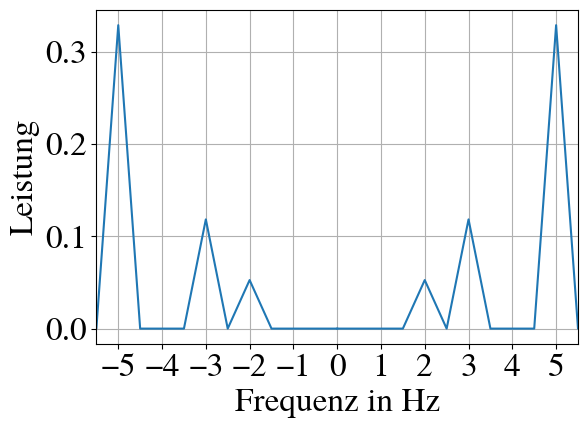

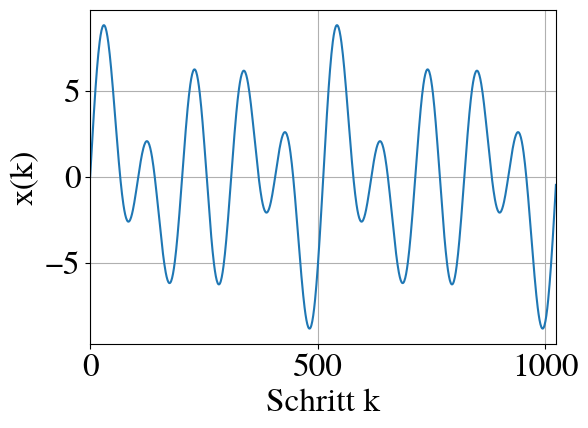

In [9]:
import matplotlib.pyplot as plt

n = 2 ** 10
T = 2.0 / n
file = "Überlagerung-fft"

y = [
    np.sum([
        5 * np.sin(5 * 2 * np.pi * T * k),
        3 * np.sin(3 * 2 * np.pi * T * k),
        2 * np.sin(2 * 2 * np.pi * T * k),
    ])
    for k in range(n)
]
reseed()
frequency_y = np.append(np.fft.fft(y, n), 0)
power = np.sum(np.abs(frequency_y) ** 2)
power_spectrum = (np.abs(frequency_y) ** 2 / (power))
freqs = np.append(np.fft.fftfreq(n, T), 0)
plt.figure()
plt.grid(True)
plt.plot(freqs[:n//2], power_spectrum[:n//2], color="#1f77b4")
plt.plot(freqs[n//2:], power_spectrum[n//2:], color="#1f77b4")
plt.xlim(-5.5, 5.5)
plt.xticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])
plt.xlabel("Frequenz in Hz", fontname="TeX Gyre Termes")
plt.ylabel("Leistung",  fontname="TeX Gyre Termes")
plt.tight_layout()
plt.savefig(f"../plots/{file}.svg")


file = "Überlagerung"
plt.figure()
plt.grid(True)
plt.plot(y)
plt.xlim(0,n)
plt.xlabel("Schritt k")
plt.ylabel("x(k)")
plt.tight_layout()
plt.savefig(f"../plots/{file}.svg")

Diagramme zu Auswirkungen auf Original-Signal wenn PSD verändert wird.

/tmp/ipykernel_2303930/4187443337.py:28: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,n//2)
/tmp/ipykernel_2303930/4187443337.py:42: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,n//2)


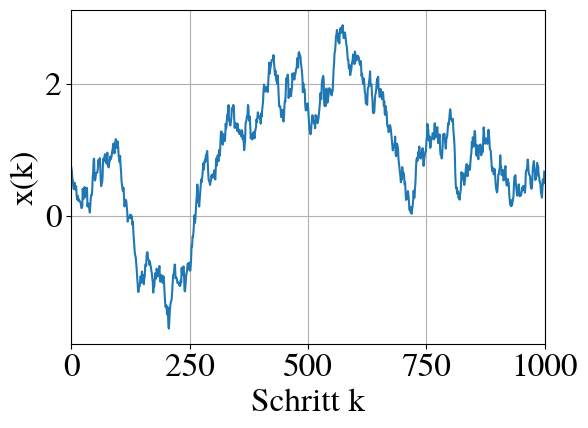

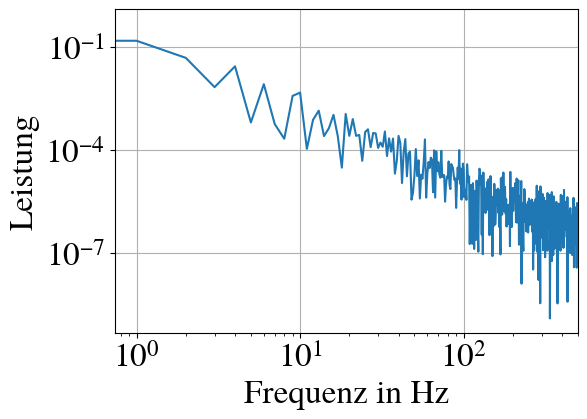

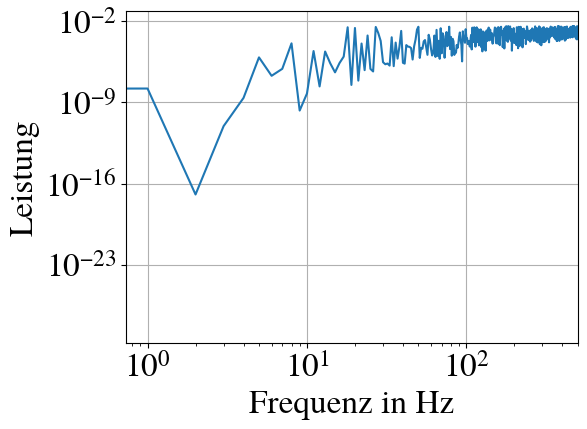

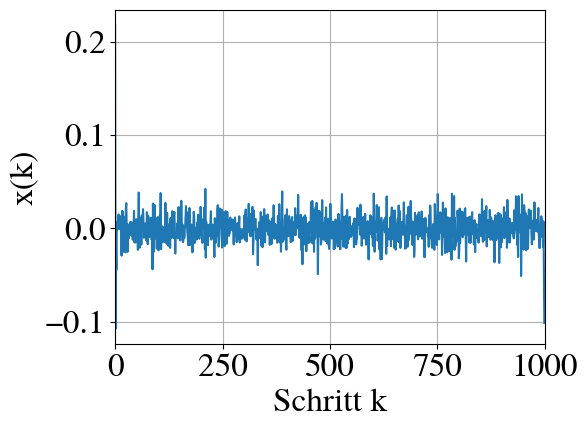

In [ ]:
import matplotlib.pyplot as plt
n = 1000
T = 1.0 / n
reseed()
y = timmer_koenig(2, n)

plt.figure()
plt.grid(True)
plt.plot(y)
plt.xlim(0,n)
plt.xlabel("Schritt k")
plt.ylabel("x(k)")
plt.tight_layout()
plt.savefig(f"../plots/PSD-Variation-Original.svg")

frequency_y = np.fft.fft(y)
power = np.sum(np.abs(frequency_y) ** 2)
power_spectrum = (np.abs(frequency_y) ** 2 / (power))
freqs = np.fft.fftfreq(n, T)

power_y = np.sum(np.abs(frequency_y) ** 2)
power_spectrum_y = (np.abs(frequency_y) ** 2 / (power_y))
plt.figure()
plt.grid(True)
plt.plot(freqs[:n//2], power_spectrum[:n//2])
plt.yscale("log")
plt.xscale("log")
plt.xlim(0,n//2)
plt.xlabel("Frequenz in Hz", fontname="TeX Gyre Termes")
plt.ylabel("Leistung",  fontname="TeX Gyre Termes")
plt.tight_layout()
plt.savefig(f"../plots/PSD-Variation-Original-psd.svg")

transformed_frequency_y = [np.exp(-frequency_y[k] ** 0.5) for k in range(n)]
transformed_power_y = np.sum(np.abs(transformed_frequency_y) ** 2)
transformed_power_spectrum_y = (np.abs(transformed_frequency_y) ** 2 / (transformed_power_y))
plt.figure()
plt.grid(True)
plt.plot(freqs[:n//2], transformed_power_spectrum_y[:n//2])
plt.yscale("log")
plt.xscale("log")
plt.xlim(0,n//2)
plt.xlabel("Frequenz in Hz", fontname="TeX Gyre Termes")
plt.ylabel("Leistung",  fontname="TeX Gyre Termes")
plt.tight_layout()
plt.savefig(f"../plots/PSD-Variation-Transformed-psd.svg")

y_transformed = np.fft.ifft(transformed_frequency_y)
plt.figure()
plt.grid(True)
plt.plot(y_transformed)
plt.xlim(0,n)
plt.xlabel("Schritt k")
plt.ylabel("x(k)")
plt.tight_layout()
plt.savefig(f"../plots/PSD-Variation-Transformed.svg")

Einzelne Diagramme zum Vergleich der Fraktionalen Differenzierung Methoden mit Auswirkung der Approximation $p$

/tmp/ipykernel_2303930/2417222553.py:16: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,n//2)
/tmp/ipykernel_2303930/2417222553.py:48: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,n//2)


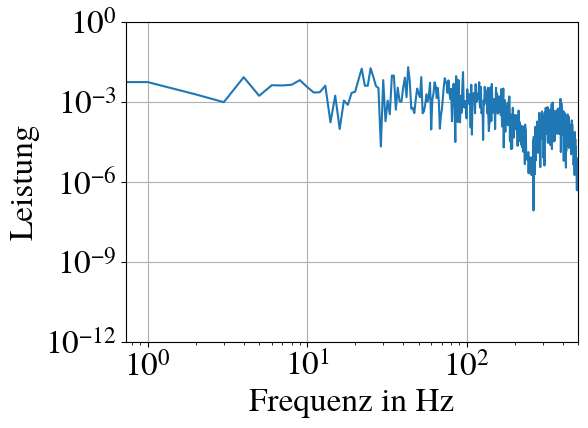

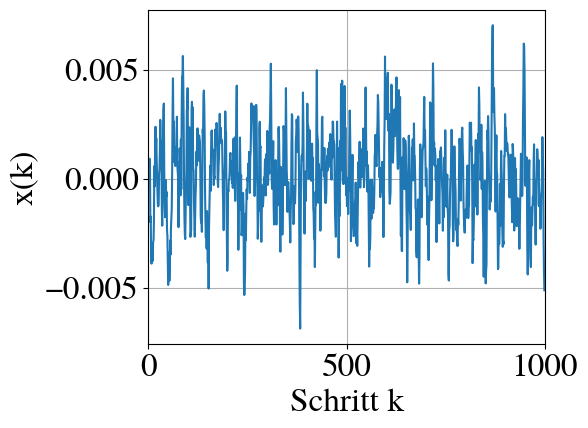

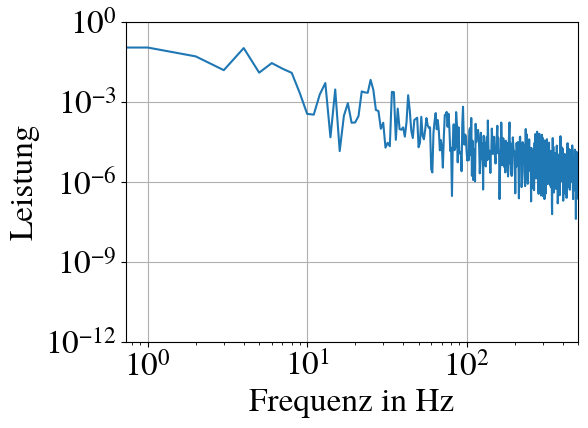

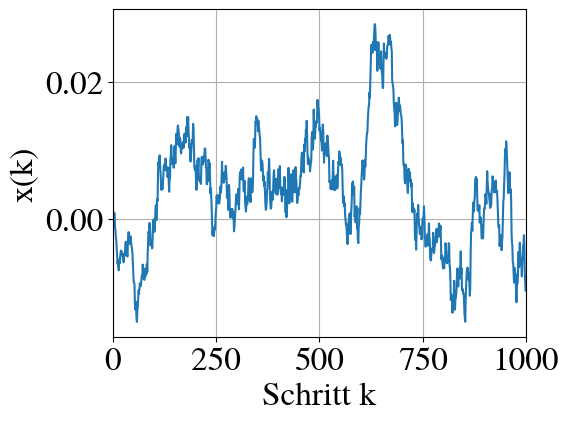

In [ ]:
import matplotlib.pyplot as plt
n = 1000
T = 1.0 / n
file = "FracDiffFreq_cutoff_5-psd"
reseed()
y = f_alpha_noise(2, n, 5)
frequency_y = np.fft.fft(y)
power = np.sum(np.abs(frequency_y) ** 2)
power_spectrum = (np.abs(frequency_y) ** 2 / (power))
freqs = np.fft.fftfreq(n, T)
plt.figure()
plt.grid(True)
plt.plot(freqs[:n//2], power_spectrum[:n//2])
plt.yscale("log")
plt.xscale("log")
plt.xlim(0,n//2)
plt.ylim(10 ** -12, 1)
plt.xlabel("Frequenz in Hz", fontname="TeX Gyre Termes")
plt.ylabel("Leistung",  fontname="TeX Gyre Termes")
plt.tight_layout()
plt.savefig(f"../plots/{file}.svg")


file = "FracDiffFreq_cutoff_5"
reseed()
y = f_alpha_noise(2, n, 5)
plt.figure()
plt.grid(True)
plt.plot(y)
plt.xlim(0,n)
plt.xlabel("Schritt k")
plt.ylabel("x(k)")
plt.tight_layout()
plt.savefig(f"../plots/{file}.svg")

file = "FracDiffFreq_cutoff_100-psd"
reseed()
y = f_alpha_noise(2, n, 100)
frequency_y = np.fft.fft(y)
power = np.sum(np.abs(frequency_y) ** 2)
power_spectrum = (np.abs(frequency_y) ** 2 / (power))
freqs = np.fft.fftfreq(n, T)
plt.figure()
plt.grid(True)
plt.plot(freqs[:n//2], power_spectrum[:n//2])
plt.yscale("log")
plt.xscale("log")
plt.xlim(0,n//2)
plt.ylim(10 ** -12, 1)
plt.xlabel("Frequenz in Hz", fontname="TeX Gyre Termes")
plt.ylabel("Leistung",  fontname="TeX Gyre Termes")
plt.tight_layout()
plt.savefig(f"../plots/{file}.svg")

file = "FracDiffFreq_cutoff_100"
reseed()
y = f_alpha_noise(2, n, 100)
plt.figure()
plt.grid(True)
plt.xlim(0,n)
plt.plot(y)
plt.xlabel("Schritt k")
plt.ylabel("x(k)")
plt.tight_layout()
plt.savefig(f"../plots/{file}.svg")

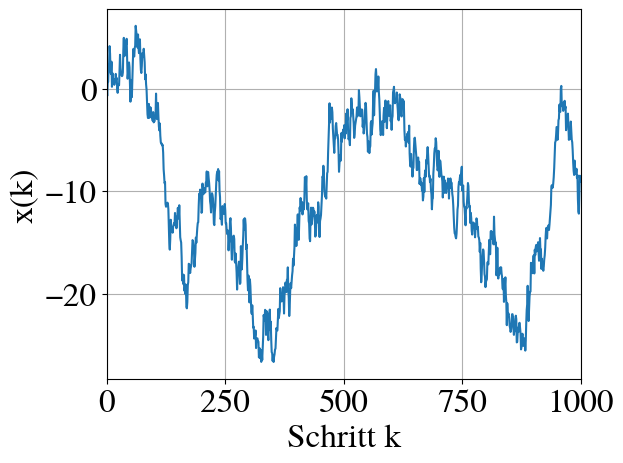

In [ ]:
file = "random_walk"
reseed()
y = random_walk(2, n)
plt.figure()
plt.grid(True)
plt.xlim(0,n)
plt.rcParams["font.size"] = 12
plt.plot(y)
plt.xlabel("Schritt k")
plt.ylabel("x(k)")
plt.tight_layout()
plt.savefig(f"../plots/{file}.svg")
plt.rcParams["font.size"] = 24

Signal- und PSD-Diagramme für alle Verfahren + Zeitmessung

In [ ]:
import os
import time
n = 1000
T = 1.0 / n
generators = [
    ("Timmer-Koenig", lambda alpha, n: powerlaw_psd_gaussian(alpha, n)),
    ("Phasenrandomisierung-Done", lambda alpha, n: done_noise(alpha, n)),
    ("FracDiffFreq", lambda alpha, n: f_alpha_noise(alpha, n)),
    ("FracDiffTime", lambda alpha, n: ar_filter_noise(alpha, n)),
    ("FracDiffTime_cutoff_5", lambda alpha, n: ar_filter_noise(alpha, n, 5)),
    ("FracDiffTime_cutoff_50", lambda alpha, n: ar_filter_noise(alpha, n, 50)),
    ("FracDiffTime_cutoff_100", lambda alpha, n: ar_filter_noise(alpha, n, 100)),
    # ("timeseries_done_naive", lambda alpha, n: timmer95_noise_naive(alpha, n)),
]
for (gen_name,gen) in generators:
    for alpha in [0, 0.5, 1, 1.5, 2]:
        reseed()
        start = time.time()
        y = gen(alpha, n)
        end = time.time()
        os.makedirs(os.path.dirname(f"../time/{n}/"), exist_ok = True)
        with open(f"../time/{n}/{gen_name}-{alpha}.yaml", 'w') as file:
            file.write(f"time: {end - start}")
        frequency_y = np.fft.fft(y)
        power = np.sum(np.abs(frequency_y) ** 2)
        power_spectrum = (np.abs(frequency_y) ** 2 / (power))
        freqs = np.fft.fftfreq(n, T)
        
        os.makedirs(os.path.dirname(f"../plots/{n}/"), exist_ok = True)
        plt.figure()
        plt.grid(True)
        plt.plot(y)
        plt.xlim(left=0,right=n)
        plt.xlabel("Schritt k",  fontname="TeX Gyre Termes")
        plt.ylabel("x(k)",  fontname="TeX Gyre Termes")
        plt.tight_layout()
        plt.savefig(f"../plots/{n}/{gen_name}-{alpha}-noise.svg")
        plt.close()
        # plt.figure()
        # plt.plot(freqs[:n//2], frequency_y[:n//2])
        plt.figure()
        plt.grid(True)
        plt.plot(freqs[:n//2], power_spectrum[:n//2])
        plt.yscale("log")
        plt.xscale("log")
        plt.xlim(0,n//2)
        plt.ylim(10 ** -12, 1)
        plt.xlabel("Frequenz in Hz",  fontname="TeX Gyre Termes")
        plt.ylabel("Leistung",  fontname="TeX Gyre Termes")
        plt.tight_layout()
        plt.savefig(f"../plots/{n}/{gen_name}-{alpha}-psd.svg")
        plt.close()


/tmp/ipykernel_2303930/3229727428.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,n//2)


Integral über alle generierten Signale

In [ ]:
import os
import time
n = 1000
T = 1.0 / n
generators = [
    ("Timmer-Koenig", lambda alpha, n: powerlaw_psd_gaussian(alpha, n)),
    ("Phasenrandomisierung-Done", lambda alpha, n: done_noise(alpha, n)),
    ("FracDiffFreq", lambda alpha, n: f_alpha_noise(alpha, n)),
    ("FracDiffTime", lambda alpha, n: ar_filter_noise(alpha, n)),
    ("FracDiffTime_cutoff_5", lambda alpha, n: ar_filter_noise(alpha, n, 5)),
    ("FracDiffTime_cutoff_50", lambda alpha, n: ar_filter_noise(alpha, n, 50)),
    ("FracDiffTime_cutoff_100", lambda alpha, n: ar_filter_noise(alpha, n, 100)),
    # ("timeseries_done_naive", lambda alpha, n: timmer95_noise_naive(alpha, n)),
]
for (gen_name,gen) in generators:
    for alpha in [0, 0.5, 1, 1.5, 2]:
        reseed()
        x = gen(alpha, n)

        os.makedirs(os.path.dirname(f"../plots/{n}/deviation/1d/"), exist_ok = True)
        plt.figure()
        plt.grid(True)
        plt.plot(x)
        plt.xlabel("Schritt k",  fontname="TeX Gyre Termes")
        plt.ylabel("x(k)",  fontname="TeX Gyre Termes")
        plt.tight_layout()
        plt.savefig(f"../plots/{n}/deviation/1d/{gen_name}-{alpha}-noise.svg")
        plt.close()

        x_sum = [np.sum(x[:i]) for i in range(0, len(x))]

        plt.figure()
        plt.xlim(0,n)
        plt.grid(True)
        plt.plot(x_sum)
        plt.xlabel("Schritt k",  fontname="TeX Gyre Termes")
        plt.ylabel("Summe x({i| i<=k})", fontname="TeX Gyre Termes")
        plt.tight_layout()
        plt.savefig(f"../plots/{n}/deviation/1d/{gen_name}-{alpha}-sum.svg")
        plt.close()

Integral über 2D-Rauschen aller Verfahren.

In [ ]:
import os
import time
n = 1000
T = 1.0 / n
generators = [
    ("Timmer-Koenig", lambda alpha, n: powerlaw_psd_gaussian(alpha, n)),
    ("Phasenrandomisierung-Done", lambda alpha, n: done_noise(alpha, n)),
    ("FracDiffFreq", lambda alpha, n: f_alpha_noise(alpha, n)),
    ("FracDiffTime", lambda alpha, n: ar_filter_noise(alpha, n)),
    ("FracDiffTime_cutoff_5", lambda alpha, n: ar_filter_noise(alpha, n, 5)),
    ("FracDiffTime_cutoff_50", lambda alpha, n: ar_filter_noise(alpha, n, 50)),
    ("FracDiffTime_cutoff_100", lambda alpha, n: ar_filter_noise(alpha, n, 100)),
    # ("timeseries_done_naive", lambda alpha, n: timmer95_noise_naive(alpha, n)),
]
for (gen_name,gen) in generators:
    for alpha in [0, 0.5, 1, 1.5, 2]:
        reseed()
        x = gen(alpha, n)
        y = gen(alpha, n)

        os.makedirs(os.path.dirname(f"../plots/{n}/deviation/"), exist_ok = True)
        plt.figure()
        plt.plot(x)
        plt.plot(y)
        plt.grid(True)
        plt.xlabel("Schritt k", fontname="TeX Gyre Termes")
        plt.ylabel("x(k)", fontname="TeX Gyre Termes")
        plt.tight_layout()
        plt.savefig(f"../plots/{n}/deviation/{gen_name}-{alpha}-noise.svg")
        plt.close()

        x_sum = [np.sum(x[:i]) for i in range(0, len(x))]
        y_sum = [np.sum(y[:i]) for i in range(0, len(y))]

        plt.figure()
        plt.grid(True)
        plt.plot(x_sum, y_sum)
        plt.xlabel("x", fontname="TeX Gyre Termes")
        plt.ylabel("y", fontname="TeX Gyre Termes")
        plt.tight_layout()
        plt.savefig(f"../plots/{n}/deviation/{gen_name}-{alpha}-sum.svg")
        plt.close()

Nicht benutzt: Diagramm mit generierten Rauschsignalen pro alpha aller Verfahren.

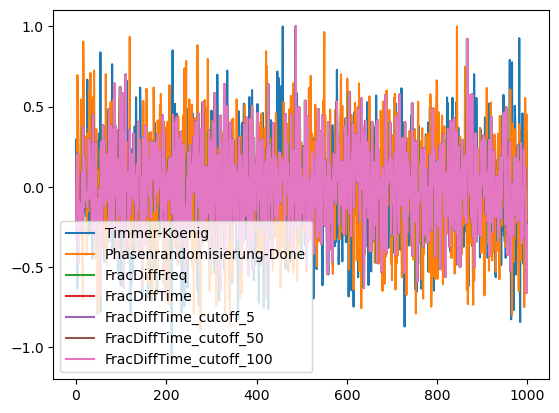

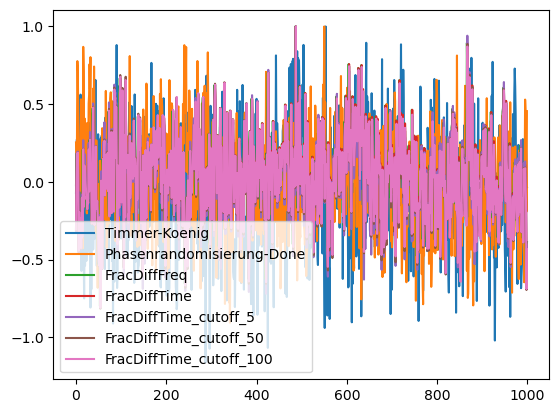

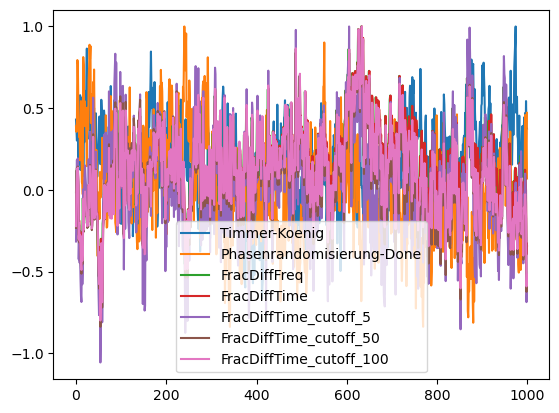

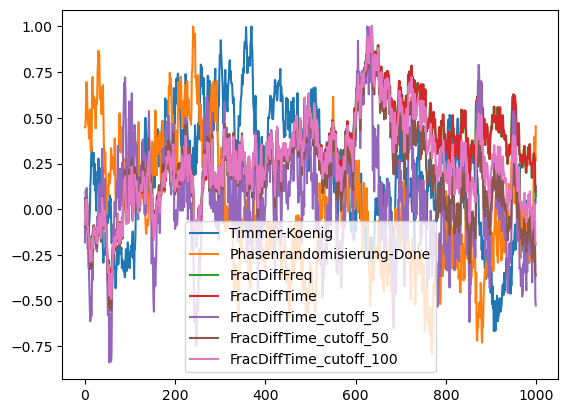

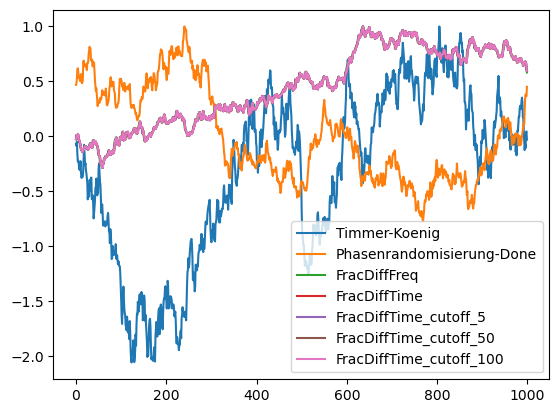

In [ ]:
import os
import time
n = 1000
T = 1.0 / n
generators = [
    ("Timmer-Koenig", lambda alpha, n: powerlaw_psd_gaussian(alpha, n)),
    ("Phasenrandomisierung-Done", lambda alpha, n: done_noise(alpha, n)),
    ("FracDiffFreq", lambda alpha, n: f_alpha_noise(alpha, n)),
    ("FracDiffTime", lambda alpha, n: ar_filter_noise(alpha, n)),
    ("FracDiffTime_cutoff_5", lambda alpha, n: ar_filter_noise(alpha, n, 5)),
    ("FracDiffTime_cutoff_50", lambda alpha, n: ar_filter_noise(alpha, n, 50)),
    ("FracDiffTime_cutoff_100", lambda alpha, n: ar_filter_noise(alpha, n, 100)),
    # ("timeseries_done_naive", lambda alpha, n: timmer95_noise_naive(alpha, n)),
]
for alpha in [0, 0.5, 1, 1.5, 2]:
    os.makedirs(os.path.dirname(f"../plots/{n}/comp/"), exist_ok = True)
    plt.figure()
    
    for (gen_name,gen) in generators:
        reseed()
        y = gen(alpha, n)

        plt.plot(y / np.abs(np.max(y)), label=gen_name)
    plt.grid(True)
    plt.legend( fontname="TeX Gyre Termes")
    plt.tight_layout()
    plt.savefig(f"../plots/{n}/comp/{alpha}-noise.svg")


Diagramme Integral 2D-Rauschen aller Verfahren + einheitliche Skalierung

In [ ]:
import os

n = 1000
T = 1.0 / n
generators = [
    ("Timmer-Koenig", lambda alpha, n: powerlaw_psd_gaussian(alpha, n)),
    ("Phasenrandomisierung-Done", lambda alpha, n: done_noise(alpha, n)),
    # ("FracDiffFreq", lambda alpha, n: f_alpha_noise(alpha, n)),
    ("FracDiffTime", lambda alpha, n: ar_filter_noise(alpha, n, 5)),
    # ("timeseries_done_naive", lambda alpha, n: timmer95_noise_naive(alpha, n)),
]
for alpha in [0, 0.5, 1, 1.5, 2]:
    data = dict()
    for (gen_name,gen) in generators:
        reseed()
        x = gen(alpha, n)
        y = gen(alpha, n)
        x_sum = [np.sum(x[:i]) for i in range(0, len(x))]
        y_sum = [np.sum(y[:i]) for i in range(0, len(y))]
        scale = max(np.max(np.abs(x_sum)), np.max(np.abs(y_sum)))
        x_sum_scaled = x_sum / scale
        y_sum_scaled = y_sum / scale

        data[gen_name] = dict()
        data[gen_name]["x"] = x
        data[gen_name]["y"] = y
        data[gen_name]["x_sum"] = x_sum
        data[gen_name]["y_sum"] = y_sum
        data[gen_name]["x_sum_scaled"] = x_sum_scaled
        data[gen_name]["y_sum_scaled"] = y_sum_scaled
    plt.figure()
    plt.grid(True)
    os.makedirs(os.path.dirname(f"../plots/{n}/deviation/combined/"), exist_ok = True)
    for (gen_name,gen) in generators:
        plt.plot(data[gen_name]["x_sum"], data[gen_name]["y_sum"], label=gen_name)
    plt.legend(fontsize=12, loc="lower right")
    plt.xlabel("x", fontname="TeX Gyre Termes")
    plt.ylabel("y", fontname="TeX Gyre Termes")
    plt.tight_layout()
    plt.savefig(f"../plots/{n}/deviation/combined/sum-{alpha}.svg")
    plt.close()

    plt.figure()
    plt.grid(True)
    os.makedirs(os.path.dirname(f"../plots/{n}/deviation/combined/"), exist_ok = True)
    for (gen_name,gen) in generators:
        plt.plot(data[gen_name]["x_sum_scaled"], data[gen_name]["y_sum_scaled"], label=gen_name)
        plt.ylim(-1,1)
        plt.xlim(-1,1)
    plt.legend(fontsize=12, loc="lower right")
    plt.xlabel("x", fontname="TeX Gyre Termes")
    plt.ylabel("y", fontname="TeX Gyre Termes")
    plt.tight_layout()
    plt.savefig(f"../plots/{n}/deviation/combined/scaled-{alpha}.svg")
    plt.close()


Diagramme zu Integral über 2D-Rauschen pro Verfahren pro Alpha 5-fach wiederholt

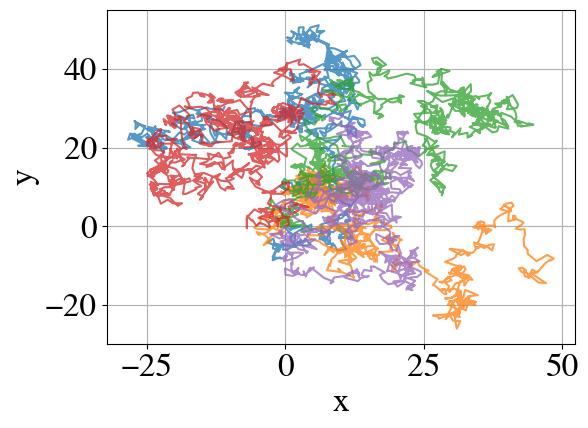

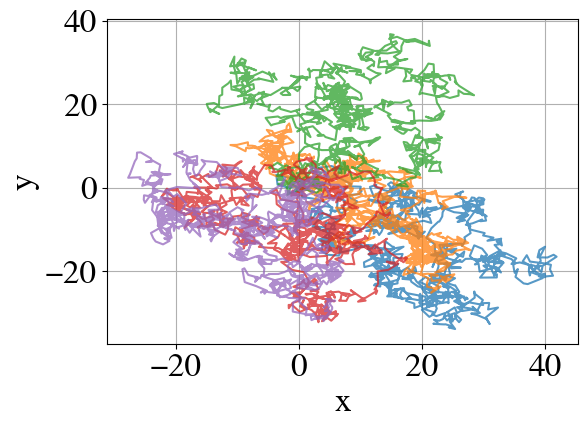

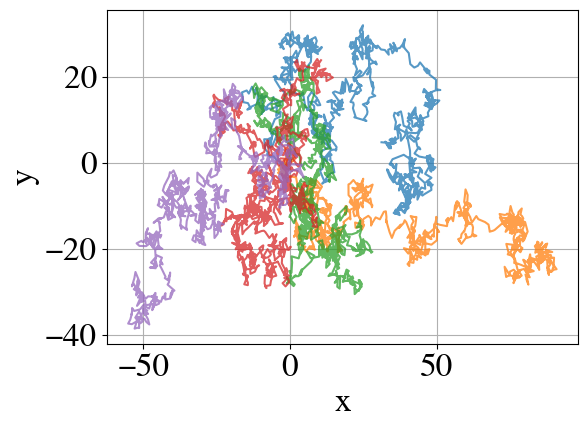

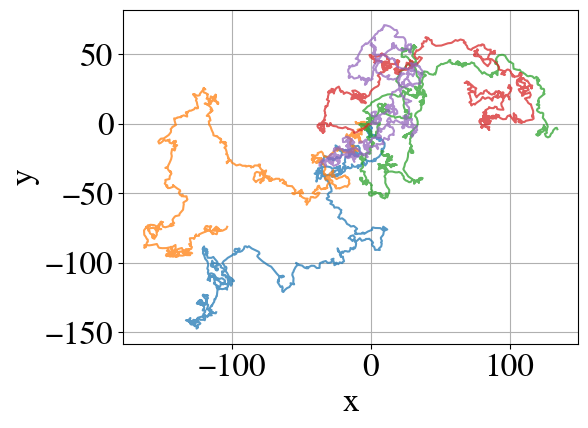

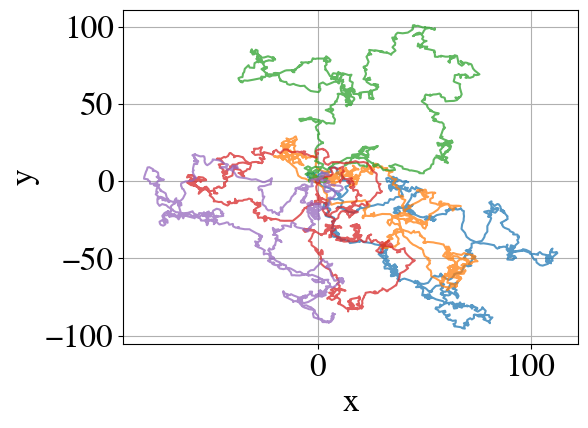

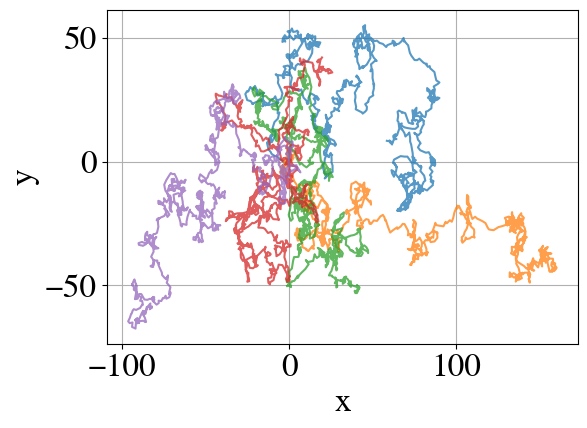

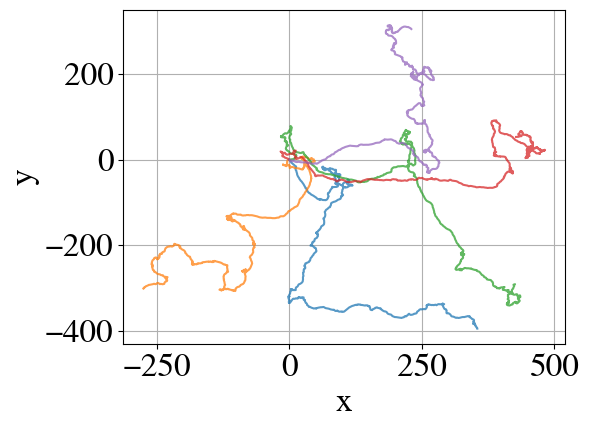

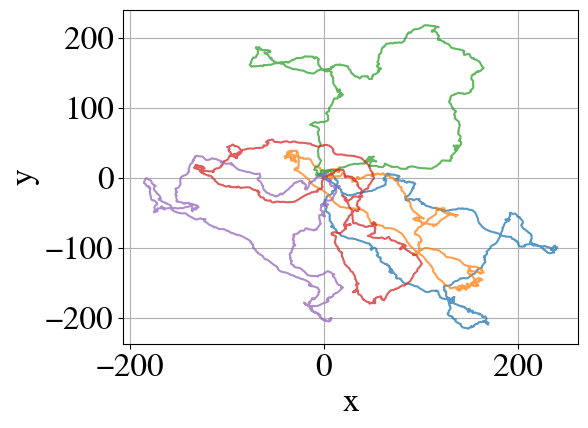

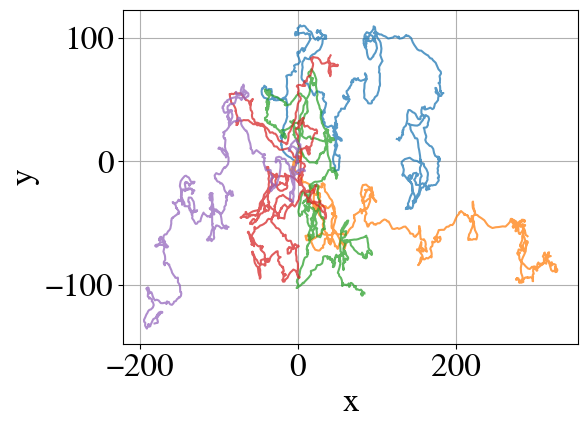

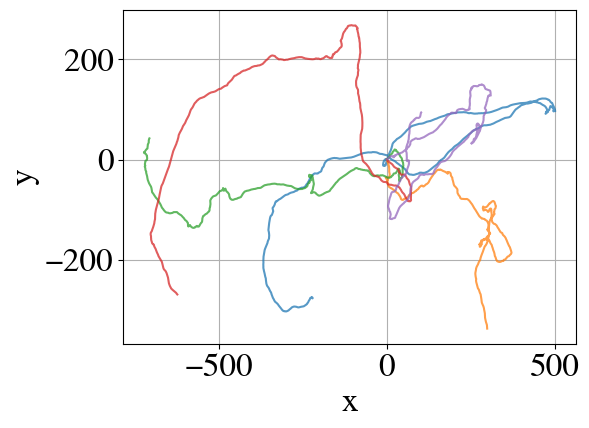

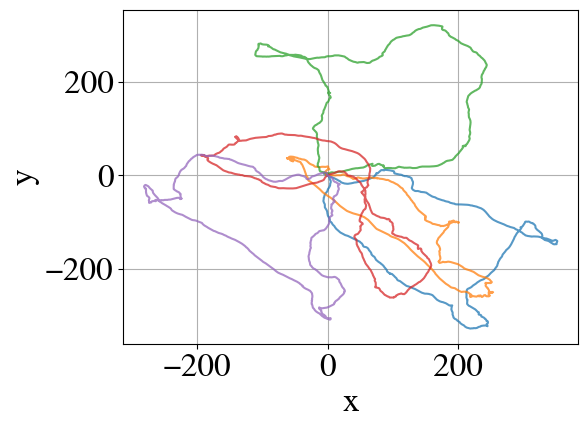

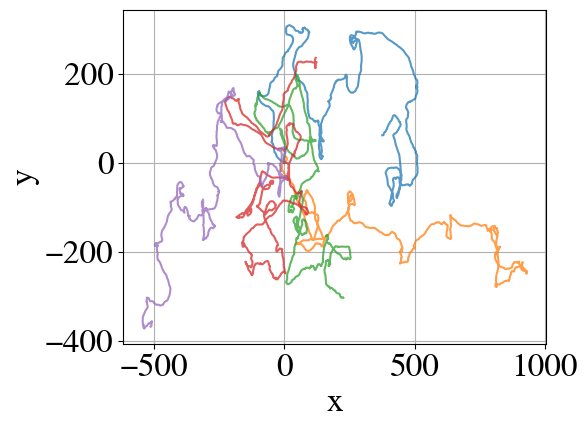

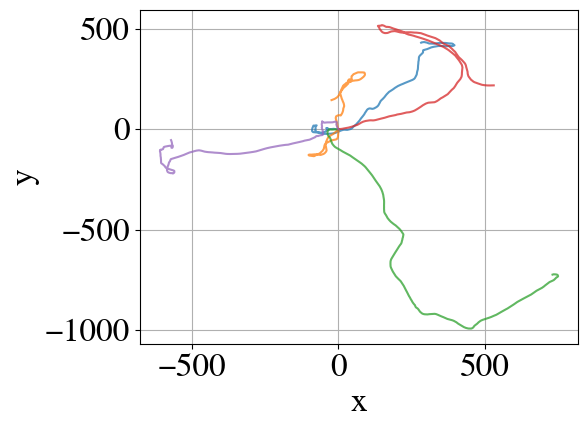

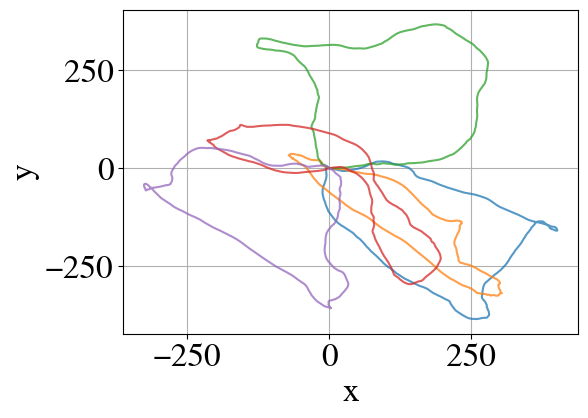

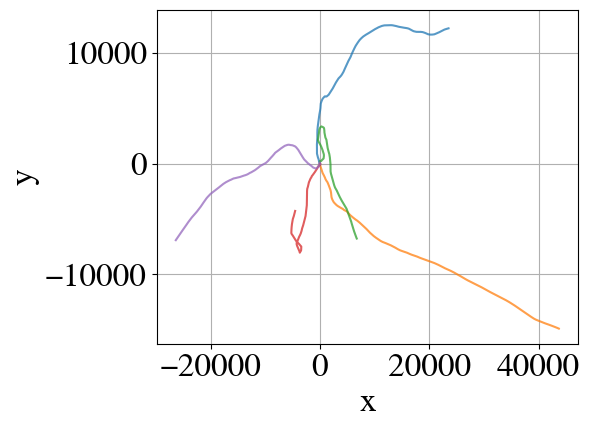

In [ ]:
import os

n = 1000
T = 1.0 / n
generators = [
    ("Timmer-Koenig", lambda alpha, n: powerlaw_psd_gaussian(alpha, n)),
    ("Phasenrandomisierung-Done", lambda alpha, n: done_noise(alpha, n)),
    # ("FracDiffFreq", lambda alpha, n: f_alpha_noise(alpha, n)),
    ("FracDiffTime", lambda alpha, n: ar_filter_noise(alpha, n, 5)),
    # ("timeseries_done_naive", lambda alpha, n: timmer95_noise_naive(alpha, n)),
]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
 '#7f7f7f', '#bcbd22', '#17becf']
for alpha in [0, 0.5, 1, 1.5, 2]:
    data = dict()
    for (gen_name,gen) in generators:
        reseed()
        data[gen_name] = dict()
        data[gen_name]["x"] = []
        data[gen_name]["y"] = []
        data[gen_name]["x_sum"] = []
        data[gen_name]["y_sum"] = []
        for i in range(5):
            x = gen(alpha, n)
            y = gen(alpha, n)
            x_sum = [np.sum(x[:i]) for i in range(0, len(x))]
            y_sum = [np.sum(y[:i]) for i in range(0, len(y))]

            data[gen_name]["x"].append(x)
            data[gen_name]["y"].append(y)
            data[gen_name]["x_sum"].append(x_sum)
            data[gen_name]["y_sum"].append(y_sum)
    os.makedirs(os.path.dirname(f"../plots/{n}/deviation/single-repeated/"), exist_ok = True)
    for c,(gen_name,gen) in enumerate(generators):
        plt.figure()
        plt.grid(True)
        for i in range(len(data[gen_name]["x_sum"])):
            plt.plot(data[gen_name]["x_sum"][i], data[gen_name]["y_sum"][i], label=gen_name, color=colors[i], alpha=0.75)
        plt.xlabel("x", fontname="TeX Gyre Termes")
        plt.ylabel("y", fontname="TeX Gyre Termes")
        plt.tight_layout()
        plt.savefig(f"../plots/{n}/deviation/single-repeated/{gen_name}-{alpha}.svg")
        # plt.close()


Jedes Verfahren x-fach wiederholen und Zeit messen

[('Timmer-Koenig', <function <lambda> at 0x6b633ccbe840>, 100.0, 0),
 ('Timmer-Koenig', <function <lambda> at 0x6b633ccbe840>, 100.0, 1),
 ('Timmer-Koenig', <function <lambda> at 0x6b633ccbe840>, 100.0, 2),
 ('Timmer-Koenig', <function <lambda> at 0x6b633ccbe840>, 100.0, 3),
 ('Timmer-Koenig', <function <lambda> at 0x6b633ccbe840>, 100.0, 4),
 ('Timmer-Koenig', <function <lambda> at 0x6b633ccbe840>, 100.0, 5),
 ('Timmer-Koenig', <function <lambda> at 0x6b633ccbe840>, 100.0, 6),
 ('Timmer-Koenig', <function <lambda> at 0x6b633ccbe840>, 100.0, 7),
 ('Timmer-Koenig', <function <lambda> at 0x6b633ccbe840>, 100.0, 8),
 ('Timmer-Koenig', <function <lambda> at 0x6b633ccbe840>, 100.0, 9),
 ('Timmer-Koenig', <function <lambda> at 0x6b633ccbe840>, 100.0, 10),
 ('Timmer-Koenig', <function <lambda> at 0x6b633ccbe840>, 100.0, 11),
 ('Timmer-Koenig', <function <lambda> at 0x6b633ccbe840>, 100.0, 12),
 ('Timmer-Koenig', <function <lambda> at 0x6b633ccbe840>, 100.0, 13),
 ('Timmer-Koenig', <function <

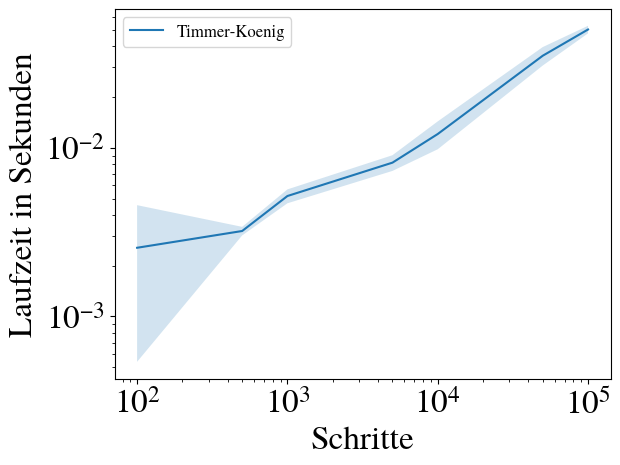

In [ ]:
import os
import time
from concurrent.futures import ThreadPoolExecutor
import pprint
import matplotlib.pyplot as plt

n = 10000
T = 1.0 / n
generators = [
    ("Timmer-Koenig", lambda alpha, n: timmer_koenig(alpha, n)),
    ("Phasenrandomisierung-Done", lambda alpha, n: done_noise(alpha, n)),
    ("FracDiffFreq", lambda alpha, n: f_alpha_noise(alpha, n)),
    ("FracDiffTime", lambda alpha, n: ar_filter_noise(alpha, n)),
    ("FracDiffTime_cutoff_5", lambda alpha, n: ar_filter_noise(alpha, n, 5)),
    ("FracDiffTime_cutoff_50", lambda alpha, n: ar_filter_noise(alpha, n, 50)),
    ("FracDiffTime_cutoff_100", lambda alpha, n: ar_filter_noise(alpha, n, 100)),
    # ("timeseries_done_naive", lambda alpha, n: done_noise_naive(alpha, n)),
]
alpha = 2
data = dict()
plt.figure()
executor = ThreadPoolExecutor()
jobs = []

def job(gen, gen_name, n):
    start = time.time()
    for i in range(1):
        gen(alpha, int(n))
    end = time.time()
    print(f"{gen_name} with n={n} done in {end - start}")
    return end - start

data['n'] = n
data["steps"] = [1e2,5e2,1e3,5e3,1e4,5e4,1e5]
# data["steps"] = [1e2,5e2,1e3, 5e3, 1e4]
data["repetitions"] = [100, 100, 50, 25, 10, 10, 5]
for (gen_name, _) in generators:
    data[gen_name] = {}
    for n in data["steps"]:
        data[gen_name][n] = []

jobs = []
for idx, n in enumerate(data["steps"]):
    jobs.extend([
        (gen_name, gen, n, rep) 
        for (gen_name, gen) in generators 
        for rep in range(data["repetitions"][idx])
    ])
pprint.pprint(jobs)
for (gen_name, gen, n, rep) in jobs:
    executor.submit(
        lambda gen_name=gen_name, gen=gen, n=n, rep=rep: 
            data[gen_name][n].append(job(gen, gen_name, n))
    )
# jobs = [ for ]
# for (gen_name,gen) in generators:
#     data[gen_name] = []

#     for n in data["steps"]:
#         jobs.append(lambda: data[gen_name].append(job(gen, gen_name, n)))

# for j in jobs:
#     executor.submit(j)

executor.shutdown()


for (gen_name, _) in generators:
    data[gen_name]["mean"] = []
    data[gen_name]["std"] = []
    for size in data["steps"]:
        data[gen_name]["mean"].append(np.mean(data[gen_name][size]))
        data[gen_name]["std"].append(np.std(data[gen_name][size]))

pprint.pprint(data)

for (gen_name, _) in generators:
    mean = data[gen_name]["mean"]
    std = data[gen_name]["std"]
    mean_lower = [mean[i] - std[i] for i in range(len(mean))]
    mean_upper = [mean[i] + std[i] for i in range(len(mean))]
    plt.plot(data["steps"], mean, label=gen_name)
    plt.fill_between(data["steps"], mean_lower, mean_upper, alpha=0.2)    
        # with open(f"../time/{n}/{gen_name}-{alpha}.yaml", 'w') as file:
        #     file.write(f"time: {end - start}")
plt.yscale("log")
plt.xscale("log")
# plt.legend(fontname="TeX Gyre Termes")
plt.legend(fontsize=12)
plt.xlabel("Schritte", fontname="TeX Gyre Termes")
plt.ylabel("Laufzeit in Sekunden", fontname="TeX Gyre Termes")
os.makedirs(os.path.dirname(f"../time/{n}/combined/"), exist_ok = True)
# plt.savefig(f"../time/{n}/combined/all.svg")
    
# plt.close()


Abspeichern der Zeit-Daten da das teilweise sehr lange dauert.

In [14]:
import yaml

save_data = {}
save_data['n'] = data['n']
save_data['steps'] = data['steps']
save_data['repetitions'] = data['repetitions']

for gen_name in data.keys():
    if not gen_name == 'steps' and not gen_name == "repetitions" and not gen_name == "n":
        save_data[gen_name] = {}
        for step in data["steps"]:
            save_data[gen_name][step] = data[gen_name][step]

with open('time_data.yaml', 'w') as file:
    yaml.dump(save_data, file, default_flow_style=False)

Laden der Zeit-Daten um ggfs. Werte zu filtern oder mehrere Durchläufe zu einem Datensatz zu fusionieren.
Muss 2x ausgeführt werden, damit alle Datensätze den Median/std/ ... bekommen.

In [17]:
import yaml
import pprint

with open('time_data.restore.yaml', 'r') as file:
    restore_data = yaml.safe_load(file)

for gen_name in data.keys():
    if not gen_name == 'steps' and not gen_name == "repetitions" and not gen_name == "n":
        restore_data[gen_name]["mean"] = []
        restore_data[gen_name]["std"] = []
        restore_data[gen_name]["q25"] = []
        restore_data[gen_name]["q50"] = []
        restore_data[gen_name]["q75"] = []

        for size in restore_data["steps"]:
            restore_data[gen_name]["mean"].append(np.mean(restore_data[gen_name][size]))
            restore_data[gen_name]["std"].append(np.std(restore_data[gen_name][size]))
            restore_data[gen_name]["q25"].append(np.percentile(restore_data[gen_name][size], 25))
            restore_data[gen_name]["q50"].append(np.percentile(restore_data[gen_name][size], 50))
            restore_data[gen_name]["q75"].append(np.percentile(restore_data[gen_name][size], 75))

pprint.pprint(restore_data)

{'FracDiffFreq': {100.0: [0.0018379688262939453,
                          0.0005409717559814453,
                          0.0041692256927490234,
                          0.0005605220794677734,
                          0.0022001266479492188,
                          0.0023794174194335938,
                          0.0016269683837890625,
                          0.00206756591796875,
                          0.0037844181060791016,
                          0.0020759105682373047,
                          0.0025322437286376953,
                          0.0026466846466064453,
                          0.004125356674194336,
                          0.004395246505737305,
                          0.004494428634643555,
                          0.004377126693725586,
                          0.004579305648803711,
                          0.004405498504638672,
                          0.0043697357177734375,
                          0.00445103645324707,
                          0.00

Diagramm zu den Laufzeiten der einzelnen Verfahren.

{'FracDiffFreq': {100.0: [0.0018379688262939453,
                          0.0005409717559814453,
                          0.0041692256927490234,
                          0.0005605220794677734,
                          0.0022001266479492188,
                          0.0023794174194335938,
                          0.0016269683837890625,
                          0.00206756591796875,
                          0.0037844181060791016,
                          0.0020759105682373047,
                          0.0025322437286376953,
                          0.0026466846466064453,
                          0.004125356674194336,
                          0.004395246505737305,
                          0.004494428634643555,
                          0.004377126693725586,
                          0.004579305648803711,
                          0.004405498504638672,
                          0.0043697357177734375,
                          0.00445103645324707,
                          0.00

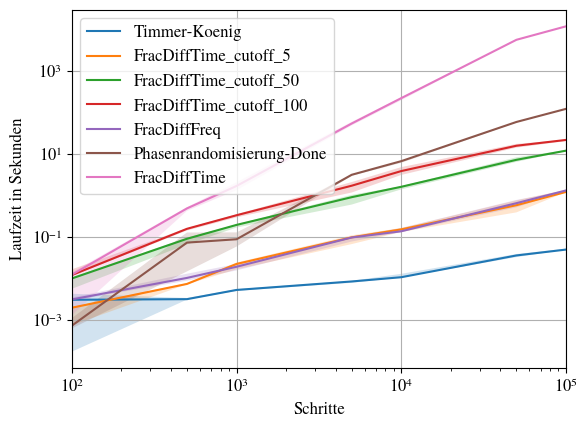

In [18]:
import pprint

data = restore_data

pprint.pprint(data)

plt.rcParams["font.size"] = 12
for gen_name in data.keys():
    if not gen_name == 'steps' and not gen_name == "repetitions" and not gen_name == "n":
        mean = data[gen_name]["mean"]
        std = data[gen_name]["std"]
        central = data[gen_name]["q50"]
        mean_lower = data[gen_name]["q25"]
        mean_upper = data[gen_name]["q75"]
        plt.grid(True)
        plt.plot(data["steps"], central, label=gen_name)
        plt.fill_between(data["steps"], mean_lower, mean_upper, alpha=0.2)    
        # with open(f"../time/{n}/{gen_name}-{alpha}.yaml", 'w') as file:
        #     file.write(f"time: {end - start}")
plt.rcParams["font.size"] = 24
plt.xlim(left=data["steps"][0], right=data["steps"][-1])
plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=12)
plt.xlabel("Schritte", fontname="TeX Gyre Termes")
plt.ylabel("Laufzeit in Sekunden", fontname="TeX Gyre Termes")
os.makedirs(os.path.dirname(f"../time/{n}/combined/"), exist_ok = True)
plt.tight_layout()
print(f"saved in: ../time/{data['n']}/combined/all.svg")
plt.savefig(f"../time/{data['n']}/combined/all.svg")
